In [26]:
import tensorflow as tf
from tensorflow.keras import datasets
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
main_folder="drive/MyDrive/dataset-resized"
import os
print(os.listdir(main_folder))

['glass', 'plastic', 'trash', 'paper', 'metal', 'cardboard']


In [19]:
!pip install split-folders

In [20]:
import splitfolders
splitfolders.ratio(main_folder, output='dataset-split', seed = 1337, ratio= (0.7,0.2,0.1), group_prefix =  None, move = False)

Copying files: 2537 files [00:08, 294.66 files/s]


In [21]:
print(os.listdir('dataset-split'))
print(os.listdir('dataset-split/train/cardboard'))

['train', 'test', 'val']
['cardboard205.jpg', 'cardboard21.jpg', 'cardboard270.jpg', 'cardboard290.jpg', 'cardboard366.jpg', 'cardboard336.jpg', 'cardboard10.jpg', 'cardboard226.jpg', 'cardboard96.jpg', 'cardboard235.jpg', 'cardboard194.jpg', 'cardboard24.jpg', 'cardboard133.jpg', 'cardboard15.jpg', 'cardboard110.jpg', 'cardboard308.jpg', 'cardboard189.jpg', 'cardboard402.jpg', 'cardboard277.jpg', 'cardboard112.jpg', 'cardboard319.jpg', 'cardboard190.jpg', 'cardboard210.jpg', 'cardboard249.jpg', 'cardboard266.jpg', 'cardboard183.jpg', 'cardboard237.jpg', 'cardboard269.jpg', 'cardboard163.jpg', 'cardboard284.jpg', 'cardboard53.jpg', 'cardboard321.jpg', 'cardboard238.jpg', 'cardboard179.jpg', 'cardboard2.jpg', 'cardboard16.jpg', 'cardboard103.jpg', 'cardboard383.jpg', 'cardboard286.jpg', 'cardboard314.jpg', 'cardboard232.jpg', 'cardboard328.jpg', 'cardboard111.jpg', 'cardboard371.jpg', 'cardboard141.jpg', 'cardboard125.jpg', 'cardboard386.jpg', 'cardboard171.jpg', 'cardboard32.jpg', 'car

In [22]:
import numpy as np

# loading training data
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(
        'dataset-split/train',
        target_size=(64, 64),
        batch_size=32,
        class_mode='categorical')

# loading testing data
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = train_datagen.flow_from_directory(
        'dataset-split/val',
        target_size=(64, 64),
        batch_size=32,
        class_mode='categorical')

Found 1773 images belonging to 6 classes.
Found 505 images belonging to 6 classes.


In [23]:
from keras.applications import MobileNetV2
from keras.layers import Dense,GlobalAveragePooling2D
from keras.models import Model
base_model=MobileNetV2(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.

cnn_mobilenetv2=base_model.output
cnn_mobilenetv2=GlobalAveragePooling2D()(cnn_mobilenetv2)
cnn_mobilenetv2=Dense(1024,activation='relu')(cnn_mobilenetv2) #we add dense layers so that the model can learn more complex functions and classify for better results.
cnn_mobilenetv2=Dense(1024,activation='relu')(cnn_mobilenetv2) #dense layer 2
cnn_mobilenetv2=Dense(512,activation='relu')(cnn_mobilenetv2) #dense layer 3
preds=Dense(6,activation='softmax')(cnn_mobilenetv2) #final layer with softmax activation
model=Model(inputs=base_model.input,outputs=preds)
#specify the inputs
#specify the outputs
#now a model has been created based on our architecture

In [24]:
for layer in model.layers[:20]:
    layer.trainable=False
for layer in model.layers[20:]:
    layer.trainable=True

In [25]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
# Adam optimizer
# loss function will be categorical cross entropy
# evaluation metric will be accuracy

step_size_train=train_generator.n//train_generator.batch_size
model_1 = model.fit(x=train_generator,validation_data = test_generator,
                   steps_per_epoch=step_size_train,
                   epochs=10)

Epoch 1/10
55/55 [==============================] - 44s 491ms/step - loss: 1.4294 - accuracy: 0.4871 - val_loss: 2.6574 - val_accuracy: 0.2158
Epoch 2/10
55/55 [==============================] - 26s 464ms/step - loss: 1.0674 - accuracy: 0.6226 - val_loss: 2.9252 - val_accuracy: 0.1901
Epoch 3/10
55/55 [==============================] - 26s 471ms/step - loss: 1.0333 - accuracy: 0.6192 - val_loss: 3.1490 - val_accuracy: 0.2436
Epoch 4/10
55/55 [==============================] - 25s 461ms/step - loss: 0.9654 - accuracy: 0.6623 - val_loss: 2.6094 - val_accuracy: 0.3030
Epoch 5/10
55/55 [==============================] - 26s 463ms/step - loss: 0.8788 - accuracy: 0.7013 - val_loss: 3.6547 - val_accuracy: 0.1980
Epoch 6/10
55/55 [==============================] - 26s 480ms/step - loss: 0.7456 - accuracy: 0.7611 - val_loss: 2.9638 - val_accuracy: 0.1901
Epoch 7/10
55/55 [==============================] - 26s 481ms/step - loss: 0.7268 - accuracy: 0.7731 - val_loss: 4.8280 - val_accuracy: 0.2099

Text(0.5, 1.0, 'Accuracy Evolution')

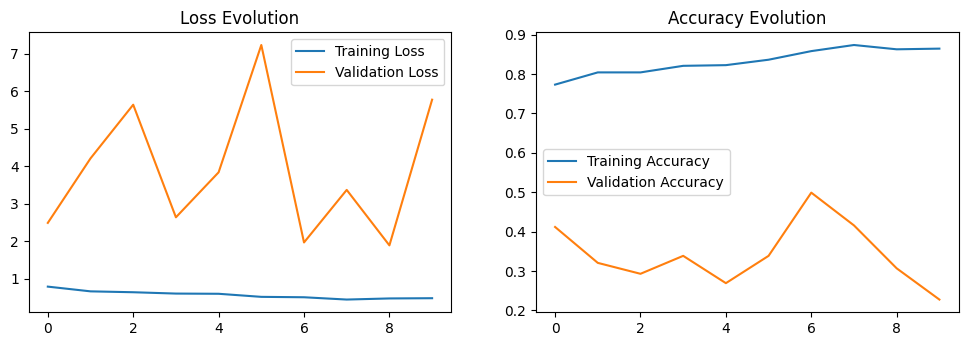

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt.plot(model_1.history['loss'], label="Training Loss")
plt.plot(model_1.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Loss Evolution")

plt.subplot(2,2,2)
plt.plot(model_1.history['accuracy'], label="Training Accuracy")
plt.plot(model_1.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Accuracy Evolution")

In [14]:
evaluation = model.evaluate(test_generator)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model.evaluate(train_generator)
print(f"TrainAccuracy: {evaluation[1] * 100:.2f}%")

16/16 [==============================] - 4s 224ms/step - loss: 5.6859 - accuracy: 0.2158
Test Accuracy: 21.58%
56/56 [==============================] - 11s 176ms/step - loss: 5.7727 - accuracy: 0.2155
TrainAccuracy: 21.55%


In [15]:
y_true = test_generator.classes
y_pred = (model.predict(test_generator) > 0.5).astype("int32")

16/16 [==============================] - 8s 350ms/step


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Convert predictions classes to one hot vectors
y_pred_classes = np.argmax(y_pred, axis = 1)

# compute the confusion matrix
classification_report = classification_report(y_true, y_pred_classes)

print(classification_report)